### Project Overview

For this project, you will use data cleaning, imputation, analysis, and visualization to generate insights for a business stakeholder.

#### Business Problem

Your company is expanding in to new industries to diversify its portfolio. Specifically, they are interested in purchasing and operating airplanes for commercial and private enterprises, but do not know anything about the potential risks of aircraft. You are charged with determining which aircraft are the lowest risk for the company to start this new business endeavor. You must then translate your findings into actionable insights that the head of the new aviation division can use to help decide which aircraft to purchase.

#### Data Analysis Goals

- Which make and models have the lowest risk for the company and for what business type are the safest investments?
- What types of flights incure the most risk and is there a correlation flight type and fatalities?
- What effect on saftey do engines have and how much is this effected by weather?

In [1]:
#standard python libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
#reading csv file into data frame for data cleaning
df = pd.read_csv('AviationData.csv', encoding = 'ISO-8859-1', low_memory=False)
df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [3]:
df.columns

Index(['Event.Id', 'Investigation.Type', 'Accident.Number', 'Event.Date',
       'Location', 'Country', 'Latitude', 'Longitude', 'Airport.Code',
       'Airport.Name', 'Injury.Severity', 'Aircraft.damage',
       'Aircraft.Category', 'Registration.Number', 'Make', 'Model',
       'Amateur.Built', 'Number.of.Engines', 'Engine.Type', 'FAR.Description',
       'Schedule', 'Purpose.of.flight', 'Air.carrier', 'Total.Fatal.Injuries',
       'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured',
       'Weather.Condition', 'Broad.phase.of.flight', 'Report.Status',
       'Publication.Date'],
      dtype='object')

In [4]:
#droping columns that are not required for answering our data questions
df = df.drop(['Publication.Date','Latitude', 'Country', 'Location', 'Event.Date', 'Accident.Number',
              'Report.Status', 'Airport.Code', 'Airport.Name', 'Registration.Number', 
              'Air.carrier', 'Amateur.Built', 'Longitude', 'FAR.Description', 'Schedule',
              'Broad.phase.of.flight', 'Event.Id'],axis=1)

In [5]:
#replacing NAN values with unkown for the following columns
df['Purpose.of.flight'].fillna(value = 'Unknown', inplace=True)
df['Engine.Type'].fillna(value = 'Unknown', inplace=True)
df['Engine.Type'] = df['Engine.Type'].map(lambda x: 'Unkown' if x == 'UNK' or x == 'None' or x == 'NONE' else x)
df['Aircraft.damage'].fillna(value = 'Unknown', inplace=True)

##### Instrument meteorological conditions (IMC) - defined as less than the minima specified for VMC

##### Visual meteorological conditions (VMC) - following are VMC

- When above 3,000ft or 1,000ft above terrain, whichever is higher:
        1500m horizontally and 1,000 ft vertically from cloud;
        Flight visibility 5km below 10,000ft and 8km above 10,000ft.
        
- When below 3,000ft or 1,000ft above terrain, whichever is higher:
         Clear of cloud and in sight of the surface;
         Flight visibility 5km.

In [6]:
#Replacing NAN values with UNK for unkown weather information
df['Weather.Condition'].fillna(value = 'UNK', inplace=True)
df['Weather.Condition'] = df['Weather.Condition'].map(lambda x: 'UNK' if x == 'Unk' else x)

In [7]:
#Removing non airplanes from data set
#All questions to be answered only apply to Airplanes
df = df[df['Aircraft.Category'] == 'Airplane']
df['Aircraft.Category'].value_counts()

Airplane    27617
Name: Aircraft.Category, dtype: int64

In [8]:
#droping nan from following two columns due to small number of NAN values
#and renaming columns for ease of use
new_column_names = {'Injury.Severity':'Severity', 'Aircraft.damage':'Aircraft Damage', 'Number.of.Engines':'Engines',
                    'Purpose.of.flight':'Purpose', 'Total.Fatal.Injuries':'Fatal', 'Total.Serious.Injuries':'Serious',
                    'Total.Minor.Injuries':'Minor', 'Total.Uninjured':'Uninjured', 'Weather.Condition':'Weather',
                    'Aircraft.Category':'Aircraft Category', 'Engine.Type':'Engine Type', 'Investigation.Type':'Investigation'}
df.rename(columns=new_column_names, inplace=True)
df = df.dropna(subset=['Make', 'Model'])

Next step is to fill in the NaN for our number catagories. 

In order to do this it needs to determined what method we will use. Such as replacing with the mean, median, etc.

In [9]:
#Removie numbers from brackets ex: fatal(29) extracted to 29
df['Fatality'] = df['Severity'].str.extract(r'\((\d+)\)')
#Fill nan values with values from Severity
df['Fatality'].fillna(df['Severity'], inplace=True)
#Replace values in df column 0 for non fatal string names
df['Fatality'].replace({'Non-Fatal': 0, 'Minor': 0, 'Serious': 0, 'Incident': 0}, inplace=True)
#returns number in 'Fatal' column for every string = 'Fatal' 
#in 'Fatality' column and copies that into 'Fatality' Column
df['Fatality'] = df.apply(lambda row: row['Fatal'] if row['Fatality'] == 'Fatal' else row['Fatality'], axis=1)
#replaces string 'Unavailable' with NaN for later conversion of the column to a number
df['Fatality'].replace('Unavailable', np.nan, inplace=True)
#convert any column that is NOT NaN into an int
df['Fatality'][~df['Fatality'].isna()] = df['Fatality'][~df['Fatality'].isna()].astype(int)
#Fill in NaN values with numbers from the Fatal column
df['Fatality'].fillna(df['Fatal'], inplace=True)
#Drop remaining NaN values. 20 NaN values remained so minimal data was lost
df.dropna(subset = ['Fatality'], inplace=True)
#Copy 'Fatality' column to 'Fatal' column and drop 'Fatality' column
df['Fatal'] = df['Fatality']
df.drop(['Fatality'],axis=1)
#Clean Severity column to catagories 'Fatal' and 'Non-Fatal'
df['Severity'] = df.apply(lambda x: 'Non-Fatal' if x['Fatal'] == 0 else 'Fatal', axis=1)
df['Severity'].value_counts()

<ipython-input-9-d6fb7f174747>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fatality'][~df['Fatality'].isna()] = df['Fatality'][~df['Fatality'].isna()].astype(int)


Non-Fatal    22410
Fatal         5150
Name: Severity, dtype: int64

In [10]:
df.isna().sum()

Investigation           0
Severity                0
Aircraft Damage         0
Aircraft Category       0
Make                    0
Model                   0
Engines              2730
Engine Type             0
Purpose                 0
Fatal                   0
Serious              3196
Minor                2851
Uninjured             874
Weather                 0
Fatality                0
dtype: int64

In [11]:
Engines_vc = df['Engines'].value_counts()
Fatal_vc = df['Fatal'].value_counts()
Serious_vc = df['Serious'].value_counts()
Minor_vc = df['Minor'].value_counts()
Uninjured_vc = df['Uninjured'].value_counts()

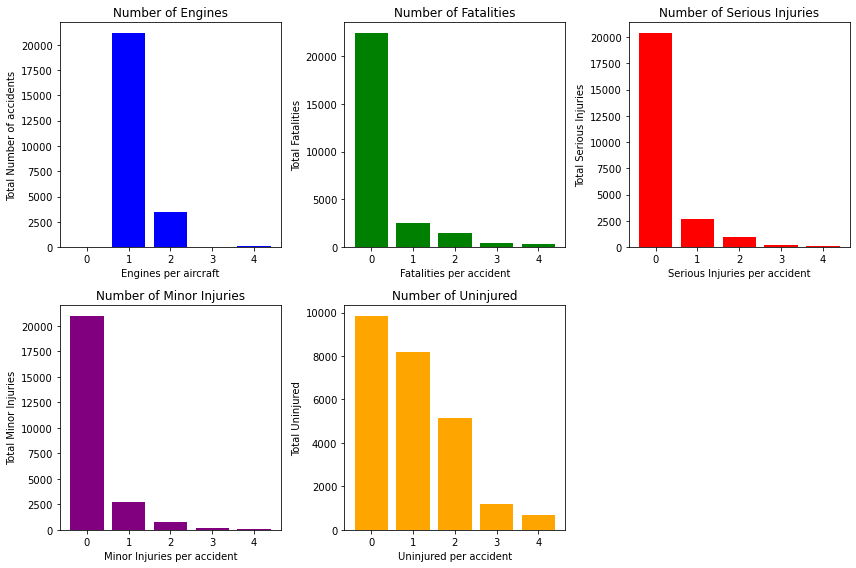

In [12]:
plt.figure(figsize=(12, 8))

# Engines
plt.subplot(2, 3, 1)
plt.bar(Engines_vc.index[0:5], Engines_vc.values[0:5], color='blue')
plt.title('Number of Engines')
plt.xlabel('Engines per aircraft')
plt.ylabel('Total Number of accidents')

# Fatalities
plt.subplot(2, 3, 2)
plt.bar(Fatal_vc.index[0:5], Fatal_vc.values[0:5], color='green')
plt.title('Number of Fatalities')
plt.xlabel('Fatalities per accident')
plt.ylabel('Total Fatalities')

# Serious
plt.subplot(2, 3, 3)
plt.bar(Serious_vc.index[0:5], Serious_vc.values[0:5], color='red')
plt.title('Number of Serious Injuries')
plt.xlabel('Serious Injuries per accident')
plt.ylabel('Total Serious Injuries')

# Minor
plt.subplot(2, 3, 4)
plt.bar(Minor_vc.index[0:5], Minor_vc.values[0:5], color='purple')
plt.title('Number of Minor Injuries')
plt.xlabel('Minor Injuries per accident')
plt.ylabel('Total Minor Injuries')

# Uninjured
plt.subplot(2, 3, 5)
plt.bar(Uninjured_vc.index[0:5], Uninjured_vc.values[0:5], color='orange')
plt.title('Number of Uninjured')
plt.xlabel('Uninjured per accident')
plt.ylabel('Total Uninjured')

plt.tight_layout()  # Adjusts spacing between subplots
plt.show()

In [13]:
df.describe()

,Engines,Fatal,Serious,Minor,Uninjured,Fatality
count,24830.000000,27560.000000,24364.000000,24709.000000,26686.000000,27560.000000
mean,1.158558,0.581023,0.297734,0.254118,6.373567,0.581023
std,0.407685,5.601674,2.099036,2.897034,31.867330,5.601674
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000
max,8.000000,295.000000,161.000000,380.000000,588.000000,295.000000


In [14]:
#based on chart data showing large positive skewing replacing NaN values for the following with median Value
df['Engines'].fillna(value = df['Engines'].median(), inplace = True)
df['Serious'].fillna(value = df['Serious'].median(), inplace = True)
df['Minor'].fillna(value = df['Minor'].median(), inplace = True)
df['Uninjured'].fillna(value = df['Uninjured'].median(), inplace = True)
df.isna().sum()

Investigation        0
Severity             0
Aircraft Damage      0
Aircraft Category    0
Make                 0
Model                0
Engines              0
Engine Type          0
Purpose              0
Fatal                0
Serious              0
Minor                0
Uninjured            0
Weather              0
Fatality             0
dtype: int64

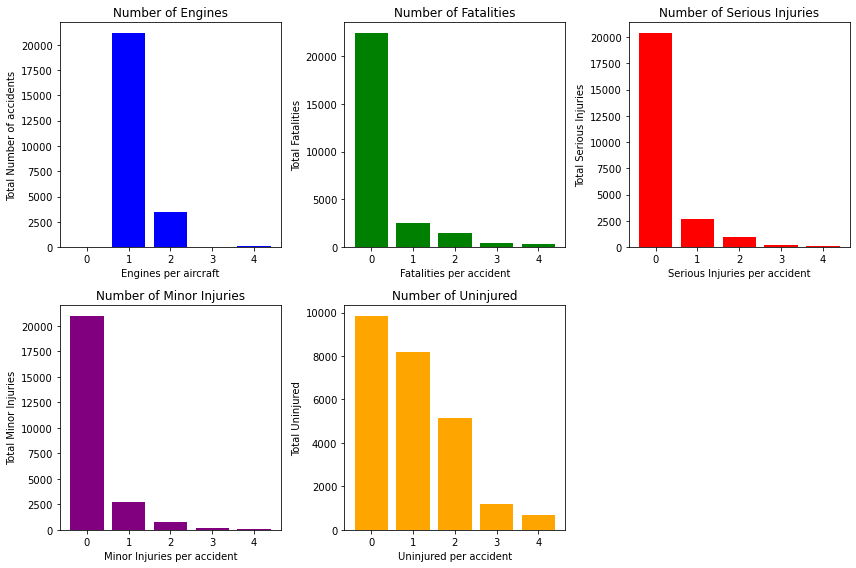

In [15]:
#updated chart to see change visually 
plt.figure(figsize=(12, 8))

# Engines
plt.subplot(2, 3, 1)
plt.bar(Engines_vc.index[0:5], Engines_vc.values[0:5], color='blue')
plt.title('Number of Engines')
plt.xlabel('Engines per aircraft')
plt.ylabel('Total Number of accidents')

# Fatalities
plt.subplot(2, 3, 2)
plt.bar(Fatal_vc.index[0:5], Fatal_vc.values[0:5], color='green')
plt.title('Number of Fatalities')
plt.xlabel('Fatalities per accident')
plt.ylabel('Total Fatalities')

# Serious
plt.subplot(2, 3, 3)
plt.bar(Serious_vc.index[0:5], Serious_vc.values[0:5], color='red')
plt.title('Number of Serious Injuries')
plt.xlabel('Serious Injuries per accident')
plt.ylabel('Total Serious Injuries')

# Minor
plt.subplot(2, 3, 4)
plt.bar(Minor_vc.index[0:5], Minor_vc.values[0:5], color='purple')
plt.title('Number of Minor Injuries')
plt.xlabel('Minor Injuries per accident')
plt.ylabel('Total Minor Injuries')

# Uninjured
plt.subplot(2, 3, 5)
plt.bar(Uninjured_vc.index[0:5], Uninjured_vc.values[0:5], color='orange')
plt.title('Number of Uninjured')
plt.xlabel('Uninjured per accident')
plt.ylabel('Total Uninjured')

plt.tight_layout()  # Adjusts spacing between subplots
plt.show()

In [16]:
df['Make'] = df['Make'].str.upper()
df['Model'] = df['Model'].str.upper()
print(len(df['Make'].unique()))
df['Make'].value_counts().nlargest(20)

3533


CESSNA                8467
PIPER                 4714
BEECH                 1691
BOEING                1313
MOONEY                 419
BELLANCA               282
GRUMMAN                251
AIRBUS                 245
MAULE                  232
AERONCA                229
AIR TRACTOR            224
CIRRUS DESIGN CORP     220
AIR TRACTOR INC        219
CHAMPION               170
LUSCOMBE               164
EMBRAER                154
STINSON                146
CIRRUS                 137
VANS                   125
NORTH AMERICAN         118
Name: Make, dtype: int64

In [17]:
#cleaning Make Column
#Droping rows with NA as the make. Only 1 row was droped.
df = df[df['Make'] != 'NA']
#looping thru index to standardize names for makes
#following method will not work for models
for item in df['Make'].value_counts().index:
    df['Make'] = df['Make'].apply(lambda x: item if item in x else x)

#following method will not work for models  
df['Make'] = df['Make'].apply(lambda x: 'DE HAVILLAND' if 'DEHAVILLAND' in x else x)
df['Make'] = df['Make'].apply(lambda x: 'AERO TECHNIK' if 'AEROTECHNIK' in x else x)
print(len(df['Make'].unique()))

2015


In [18]:
len(df['Model'].value_counts())

5067

In [32]:
# df['Model'] = df['Model'].str.replace('-', ' ')
# #df['Model'] = df['Model'].apply(str_clean)
# df['Model'] = df['Model'].apply(lambda x: x.split(" ", 2)[0] if len(x.split(" ", 2)) > 1 else x)
# #df['Model'].value_counts().sort_values(ascending=False)

# df['Model'].value_counts()
df['Purpose'].value_counts()

Personal                     16138
Unknown                       4588
Instructional                 3211
Aerial Application            1066
Business                       784
Positioning                    358
Flight Test                    226
Ferry                          176
Aerial Observation             170
Skydiving                      166
Other Work Use                 158
Executive/corporate            151
Banner Tow                      89
Air Race show                   74
Public Aircraft - Federal       53
Public Aircraft                 43
Glider Tow                      35
Public Aircraft - State         24
Firefighting                    17
Public Aircraft - Local         12
Air Race/show                    7
ASHO                             6
Air Drop                         3
PUBS                             3
External Load                    1
Name: Purpose, dtype: int64

In [38]:
# Trying to see the relationship between Makes, Models and engine types with accidents 
make_model_purpose_counts = df.groupby(['Make', 'Model', 'Purpose']).size().reset_index(name='AccidentCount', drop=False)
make_model_purpose_counts = make_model_purpose_counts.sort_values(by='AccidentCount', ascending=False)
make_model_purpose_counts = make_model_purpose_counts[make_model_purpose_counts['Purpose']!='Unkown']
make_model_purpose_counts

,Make,Model,Purpose,AccidentCount
2177,CESSNA,172,Personal,444
1544,BOEING,737,Unknown,401
2175,CESSNA,172,Instructional,303
2138,CESSNA,152,Instructional,261
2368,CESSNA,182,Personal,222
...,...,...,...,...
3800,DE HAVILLAND,DHC8 - 102,Unknown,1
3796,DE HAVILLAND,DHC3,Instructional,1
3793,DE HAVILLAND,DHC2,Aerial Observation,1
3792,DE HAVILLAND,DHC-II,Unknown,1


In [39]:
make_model_accident_counts = df.groupby(['Make', 'Model']).size().reset_index(name='AccidentCount', drop=False)
make_model_accident_counts = make_model_accident_counts.sort_values(by='AccidentCount', ascending=False)
make_model_accident_counts

,Make,Model,AccidentCount
1644,CESSNA,172,868
1629,CESSNA,152,451
1119,BOEING,737,404
1711,CESSNA,182,345
1676,CESSNA,172N,316
...,...,...,...
2872,EVENS,RV-6,1
2871,EVENS,BEARHAWK PATROL,1
2869,EVEKTOR,EV97,1
2868,EUROPRO CZ,EUROFOX,1


In [33]:
# Investigation        0
# Severity             0
# Aircraft Damage      0
# Aircraft Category    0
# Make                 0
# Model                0
# Engines              0
# Engine Type          0
# Purpose              0
# Fatal                0
# Serious              0
# Minor                0
# Uninjured            0
# Weather              0
# Fatality             0
accident.describe()

,AccidentCount
count,5.000000
mean,476.800000
std,224.850395
min,316.000000
25%,345.000000
50%,404.000000
75%,451.000000
max,868.000000


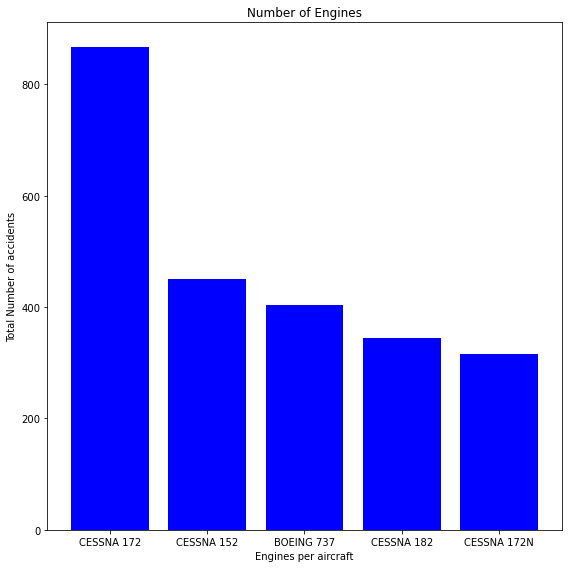

In [36]:
plt.figure(figsize=(8, 8))

# Engines
plt.bar(accident['Make'] + ' ' + accident['Model'], accident['AccidentCount'], color='blue')
plt.title('Number of Engines')
plt.xlabel('Engines per aircraft')
plt.ylabel('Total Number of accidents')

plt.tight_layout()  # Adjusts spacing between subplots
plt.show()

In [42]:
make_model_purpose_counts['Purpose'].value_counts()

Personal                     4826
Unknown                      1551
Instructional                 771
Business                      436
Positioning                   267
Flight Test                   220
Aerial Application            172
Ferry                         161
Other Work Use                127
Aerial Observation            113
Executive/corporate           109
Air Race show                  69
Skydiving                      65
Banner Tow                     49
Public Aircraft - Federal      44
Public Aircraft                40
Glider Tow                     25
Public Aircraft - State        20
Public Aircraft - Local        12
Firefighting                   11
Air Race/show                   7
ASHO                            6
PUBS                            3
Air Drop                        3
External Load                   1
Name: Purpose, dtype: int64

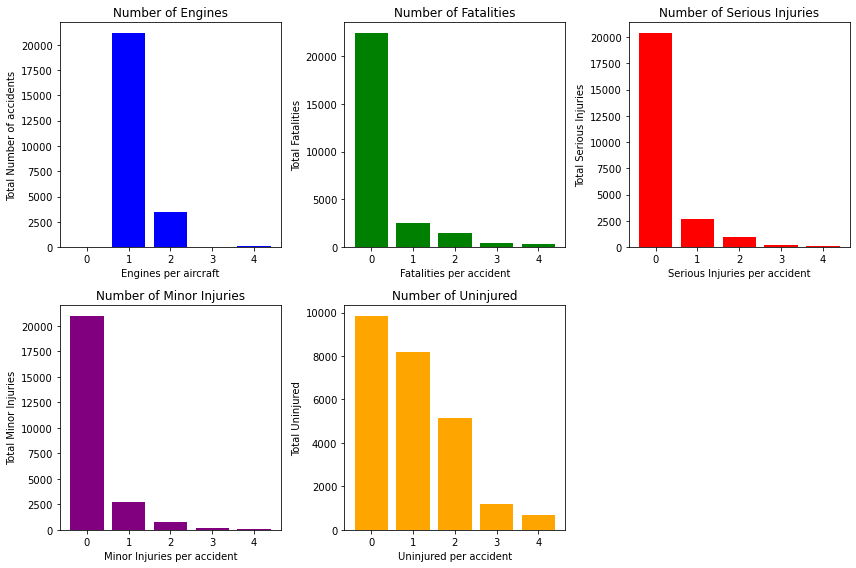

In [37]:
Personal = make_model_purpose_counts['Personal'].tail()
Business = make_model_purpose_counts['Personal'].tail()
Instructional = make_model_purpose_counts['Personal'].tail()
Executive = make_model_purpose_counts['Personal'].tail()

#make_model_purpose_counts
plt.figure(figsize=(12, 8))

# Total Accidents
plt.subplot(2, 3, 1)
plt.bar(Engines_vc.index[0:5], Engines_vc.values[0:5], color='blue')
plt.title('Number of Engines')
plt.xlabel('Engines per aircraft')
plt.ylabel('Total Number of accidents')

# Fatalities
plt.subplot(2, 3, 2)
plt.bar(Fatal_vc.index[0:5], Fatal_vc.values[0:5], color='green')
plt.title('Number of Fatalities')
plt.xlabel('Fatalities per accident')
plt.ylabel('Total Fatalities')

# Serious
plt.subplot(2, 3, 3)
plt.bar(Serious_vc.index[0:5], Serious_vc.values[0:5], color='red')
plt.title('Number of Serious Injuries')
plt.xlabel('Serious Injuries per accident')
plt.ylabel('Total Serious Injuries')

# Minor
plt.subplot(2, 3, 4)
plt.bar(Minor_vc.index[0:5], Minor_vc.values[0:5], color='purple')
plt.title('Number of Minor Injuries')
plt.xlabel('Minor Injuries per accident')
plt.ylabel('Total Minor Injuries')

# Uninjured
plt.subplot(2, 3, 5)
plt.bar(Uninjured_vc.index[0:5], Uninjured_vc.values[0:5], color='orange')
plt.title('Number of Uninjured')
plt.xlabel('Uninjured per accident')
plt.ylabel('Total Uninjured')

# Uninjured
plt.subplot(2, 3, 5)
plt.bar(Uninjured_vc.index[0:5], Uninjured_vc.values[0:5], color='orange')
plt.title('Number of Uninjured')
plt.xlabel('Uninjured per accident')
plt.ylabel('Total Uninjured')

plt.tight_layout()  # Adjusts spacing between subplots
plt.show()

In [ ]:
# df.groupby(['Make', 'Model']).max()

In [ ]:
# print(len(df['Model'].unique()))
# print(len(df['Make'].unique()))
# df['Accident Counter'] = 1
# df.groupby(['Make', 'Model']).sum()

In [ ]:
# df['Make'] = df['Make'].apply(lambda x: 'DE HAVILLAND' if 'DEHAVILLAND' in x else x)
# # df['Make'] = df['Make'].apply(lambda x: 'DE HAVILLAND' if 'DEHAVILLAND' in x else x)
# # df['Make'] = df['Make'].apply(lambda x: 'DE HAVILLAND' if 'DEHAVILLAND' in x else x)
# df['Make'] = df['Make'].apply(lambda x: 'AERO TECHNIK' if 'AEROTECHNIK' in x else x)